## Group No: 89

## Group Member Names:
1. ANAND MOHAN AWASTHI
2. ANANDRAJ K
3. SAPPA BABY NEEHARIKA
4. PRAKASH KUMAR ROUT

## Journal used for the implemetation
Journal title: TrOCR: Transformer-based Optical Character Recognition with Pretrained Models

Authors:Minghao Li, Tengchao Lv, Jingye Chen, Lei Cui, Yijuan Lu, Dinei Florencio, Cha Zhang, Zhoujun Li, and Furu Wei.

Journal Name:TrOCR uses Transformer-based models for text recognition

Year: 2021

# Content
* ### License Plate Text Recognition using Transformer
    *     ### Import the required libraries
    *     ### Lib. version
    *     ### Constant
    *     ### Ingest, Preprocess, & Split Dataset (into Training & Testing Datasets)
    *     ### Create Custom Dataset ClassCreate Custom Dataset Class
    *     ### Print Length of Training & Testing Datasets
    *     ### Example of Input Data Shapes
    *     ### Show Example
    *     ### Model Configuration
    *     ### Define Training Arguments
    *     ### Define Trainer
    *     ### Fit/Train Model
    *     ### Save Model & Training Metrics
    *     ### Evaluate Model
    *     ### Inference Test Image
    *     ### Inference Test Image Dim
    *     ### Load model from Output Dir.
    *     ### Inference Model Configuration
    *     ### Inference model prediction

# License Plate Text Recognition using Transformer

### 1. Import the required libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os, sys, itertools
import pandas as pd
import torch
import datasets
import transformers
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, VisionEncoderDecoderModel, TrOCRProcessor, default_data_collator
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset
from datasets import load_dataset, load_metric

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, log_loss


In [ ]:
!pip install -q datasets jiwer

### Lib. version

In [ ]:
print("Python:", sys.version[0:6])
print("Pandas:", pd.__version__)
print("Datasets:", datasets.__version__)
print("Transformers:", transformers.__version__)
print("Torch:", torch.__version__)

Python: 3.10.1
Pandas: 1.5.3
Datasets: 2.1.0
Transformers: 4.30.2
Torch: 2.0.0


### Constants

In [ ]:
MODEL_CKPT = "microsoft/trocr-base-printed"
MODEL_NAME =  MODEL_CKPT.split("/")[-1] + "_lp"
NUM_OF_EPOCHS = 2
ROOT_DIR = "/kaggle/input/license-plate-text-recognition-dataset/"
LABEL_FILE_NAME = "lpr.csv"
IMAGE_FILE_DIR = "cropped_lps/cropped_lps/"

### 2. Data Acquisition
Perform the data prepracessing that is required for the data that you have downloaded.

This stage depends on the dataset that is used.

In [ ]:
df = pd.read_csv("/kaggle/input/license-plate-text-recognition-dataset/lpr.csv")
df = df.drop("Unnamed: 0", axis=1)
df.images = "/kaggle/input/license-plate-text-recognition-dataset/cropped_lps/cropped_lps/" + df.images

### 3. Data Preparation

Perform the data prepracessing that is required for the data that you have downloaded.


This stage depends on the dataset that is used.

In [ ]:
labels = df.labels.values.tolist()
images = df.images.values.tolist()

MAX_LENGTH = max([len(label) for label in labels])

labels = [label.ljust(MAX_LENGTH) for label in labels]

characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  20000
Number of labels found:  20000
Number of unique characters:  34
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


### Ingest, Preprocess, & Split Dataset (into Training & Testing Datasets)

In [ ]:
train_dataset, test_dataset = train_test_split(df, train_size=0.80, random_state=42)

train_dataset.reset_index(drop=True, inplace=True)
test_dataset.reset_index(drop=True, inplace=True)

print(train_dataset.info())
print(test_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  16000 non-null  object
 1   labels  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  4000 non-null   object
 1   labels  4000 non-null   object
dtypes: object(2)
memory usage: 62.6+ KB
None


### Create Custom Dataset Class

In [ ]:
class LP_Dataset(Dataset):

    def __init__(self, df, processor, max_target_length=128):
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['images'][idx]
        text = self.df['labels'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, padding="max_length", max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id
                  else -100 for label in labels]

        encoding = {"pixel_values" : pixel_values.squeeze(), "labels" : torch.tensor(labels)}
        return encoding

### Instantiate Processor, Create Training, & Testing Dataset Instances

In [ ]:
#processor = TrOCRProcessor.from_pretrained(MODEL_CKPT)
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")
root_dir = ROOT_DIR + IMAGE_FILE_DIR;
train_ds = LP_Dataset(df=train_dataset,processor=processor)

test_ds = LP_Dataset(df=test_dataset, processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Print Length of Training & Testing Datasets

In [ ]:
print(f"The training dataset has {len(train_ds)} samples in it.")
print(f"The testing dataset has {len(test_ds)} samples in it.")

The training dataset has 16000 samples in it.
The testing dataset has 4000 samples in it.


### Example of Input Data Shapes

In [ ]:
encoding = train_ds[0]

for k,v in encoding.items():
    print(k, " : ", v.shape)

pixel_values  :  torch.Size([3, 384, 384])
labels  :  torch.Size([128])


### Show Example

Label: 2730UB Image:


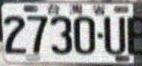

In [ ]:
image = Image.open(train_dataset['images'][0]).convert("RGB")
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print('Label:', label_str, 'Image:')
image


### 4. Deep Neural Network Architecture

### Model Configuration

In [ ]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

### 4.1 Design the architecture that you will be using

* CNN / RNN / Transformer as per the journal referenced

In [ ]:
model

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

### Define Metrics Evaluation

In [ ]:
cer_metric = load_metric("cer")
#acc_metric = load_metric("accuracy")
def compute_metrics(pred):
    label_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(label_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)
        # Calculate accuracy
    #acc = acc_metric.compute(predictions=pred_str, references=label_str)
    return {"cer" : cer}

### Define Training Arguments

In [ ]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=False,
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
    report_to="wandb"
)

### Define Trainer

In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=default_data_collator,
)

### 4.2 DNN Report

Report the following and provide justification for the same.

* Number of layers
* Number of units in each layer
* Total number of trainable parameters

Number of Layers:
For the Vision Encoder (ViTModel), there are 12 layers in the encoder stack. This is indicated by (0-11): 12 x ViTLayer.
For the Text Decoder (TrOCRDecoderWrapper), there are also 12 layers in the decoder stack, as shown by (0-11): 12 x TrOCRDecoderLayer.
So, the total number of layers in the model is 12 for both the encoder and decoder, making it a total of 24 layers.

Number of Units in Each Layer:

In the Vision Encoder, each layer of the ViTLayer has 768 units in its hidden layers. This is indicated by the size of the linear transformations, e.g., (query): Linear(in_features=768, out_features=768, bias=False) and (dense): Linear(in_features=3072, out_features=768, bias=True).

In the Text Decoder, each layer of the TrOCRDecoderLayer has 1024 units in its hidden layers, as shown by (k_proj): Linear(in_features=1024, out_features=1024, bias=True).

Total Trainable Parameters = 333921792(Sum of (Number of Weights + Number of Biases) for all layers)

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters:", total_params)


Total Trainable Parameters: 333921792


### 6. Test the model

### Fit/Train Model

In [ ]:
train_results = trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Cer
200,0.415300,0.609433,0.107667
400,0.355000,0.363529,0.064792
600,0.229000,0.379312,0.057375
800,0.201500,0.296761,0.053292
1000,0.156900,0.283051,0.053208
1200,0.206400,0.259601,0.046333
1400,0.142500,0.203614,0.041792
1600,0.170800,0.196299,0.041542
1800,0.028600,0.184708,0.040583
2000,0.244100,0.171630,0.037458


### Save Model & Training Metrics

In [ ]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =           3.0
  total_flos               = 33450954750GF
  train_loss               =        0.2512
  train_runtime            =    6:16:31.12
  train_samples_per_second =         2.125
  train_steps_per_second   =         0.133


### Evaluate Model

In [ ]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        3.0
  eval_cer                =     0.0343
  eval_loss               =     0.1513
  eval_runtime            = 0:17:26.59
  eval_samples_per_second =      3.822
  eval_steps_per_second   =      0.239


### 7. Report the result

1. Plot the training and validation accuracy history.
2. Plot the training and validation loss history.
3. Report the testing accuracy and loss.
4. Show Confusion Matrix for testing dataset.
5. Report values for preformance study metrics like accuracy, precision, recall, F1 Score.

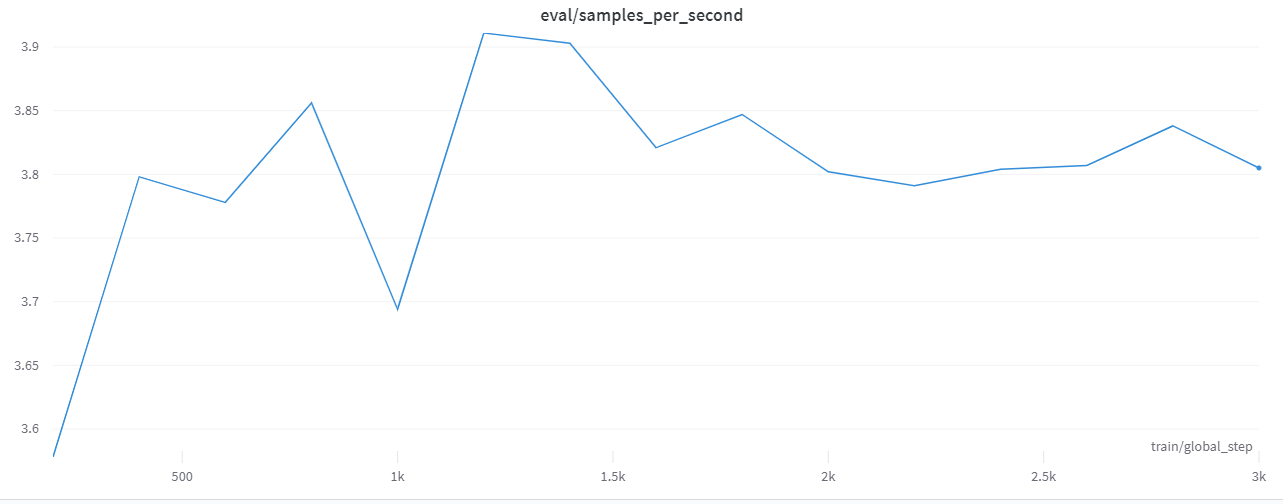

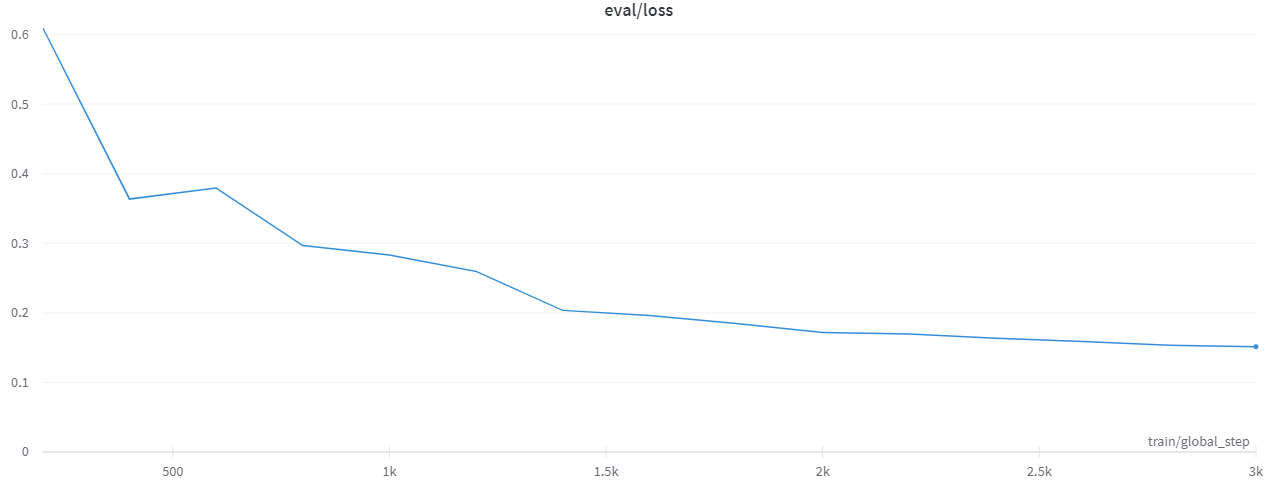

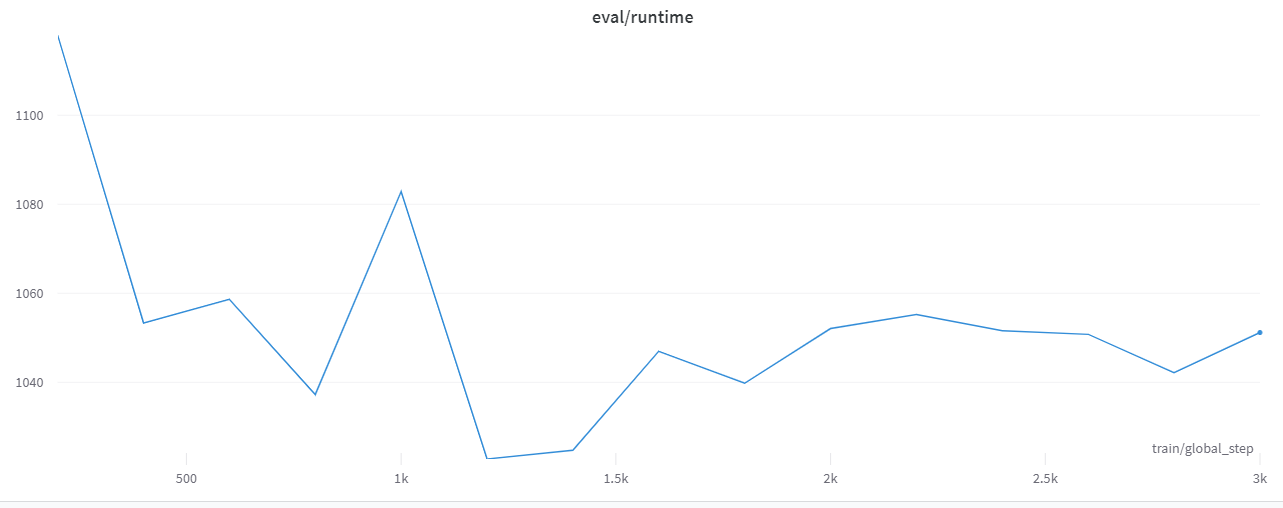

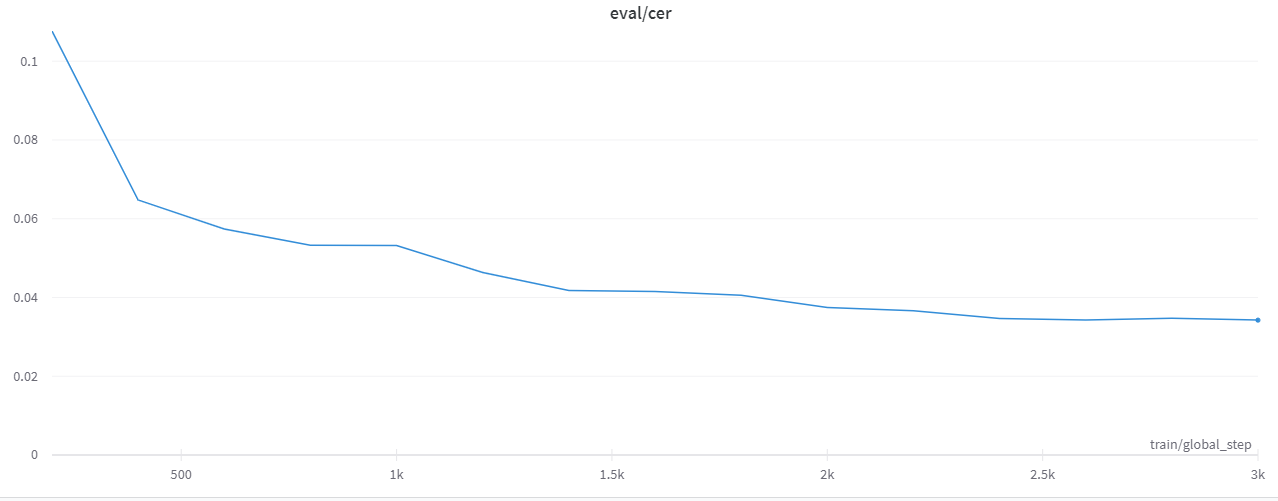

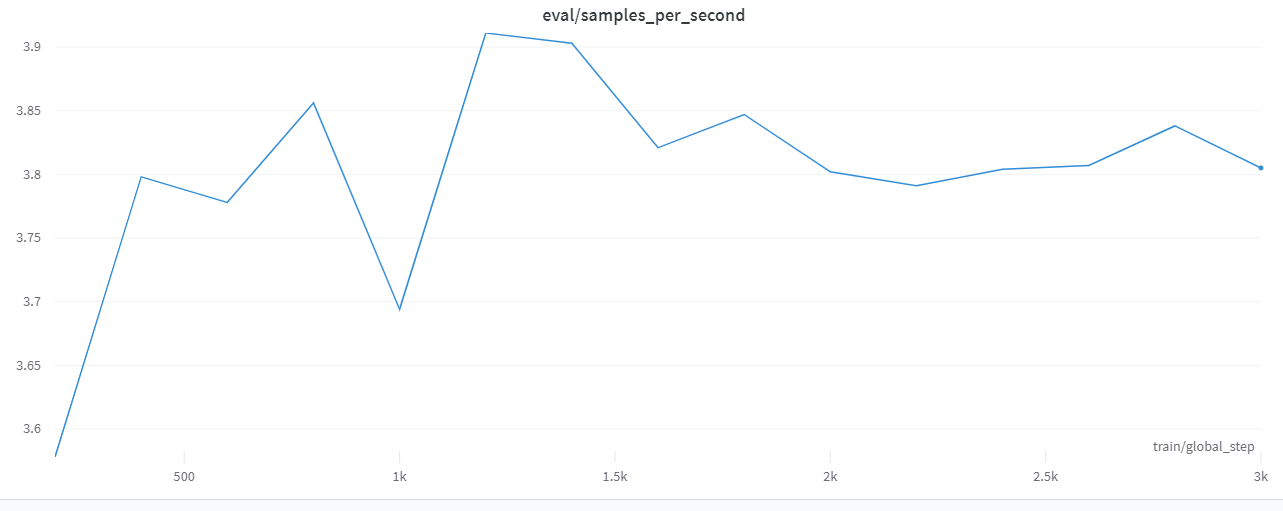

### Inference

In [ ]:
test_idx = 0
test_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
test_file_name = test_dataset['images'][test_idx]
test_text = test_dataset['labels'][test_idx]
# prepare image (i.e. resize + normalize)
test_image = Image.open(test_file_name).convert("RGB")
test_pixel_values = test_processor(test_image, return_tensors="pt").pixel_values

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


### Inference Test Image

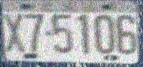

In [ ]:
test_image

### Inference Test Image Dim

In [ ]:
test_pixel_values.shape

torch.Size([1, 3, 384, 384])

### Load model from Output Dir.

In [ ]:
test_model = VisionEncoderDecoderModel.from_pretrained("./")

### Inference Model Configuration

In [ ]:
test_model.config.decoder_start_token_id = test_processor.tokenizer.cls_token_id
test_model.config.pad_token_id = test_processor.tokenizer.pad_token_id

test_model.config.vocab_size = test_model.config.decoder.vocab_size

test_model.config.eos_token_id = test_processor.tokenizer.sep_token_id
test_model.config.max_length = 64
test_model.config.early_stopping = True
test_model.config.no_repeat_ngram_size = 3
test_model.config.length_penalty = 2.0
test_model.config.num_beams = 4

### Inference model prediction

In [ ]:
generated_ids = test_model.generate(test_pixel_values)
generated_text = test_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

X75106
